In [1]:
import pandas as pd

df = pd.read_csv('data/celeba/list_attr_celeba.csv')

In [2]:
import os 
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd


class CelebAGenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        attr_path = os.path.join(root_dir, 'list_attr_celeba.csv')
        if not os.path.exists(attr_path):
            raise FileNotFoundError(f"Attribute file not found at {attr_path}")
        
        self.attr_df = pd.read_csv(attr_path)
        self.records = []
        for _, row in self.attr_df.iterrows():
            fname = row['image_id']
            label = row['Male']
            if label == -1:
                label = 0
            self.records.append((fname,label))

    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, idx):
        fname, label = self.records[idx]
        img_path = os.path.join(self.root_dir, 'img_align_celeba', fname)
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [3]:
import os 
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd


class CelebAGenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        attr_path = os.path.join(root_dir, 'list_attr_celeba.csv')
        if not os.path.exists(attr_path):
            raise FileNotFoundError(f"Attribute file not found at {attr_path}")
        
        self.attr_df = pd.read_csv(attr_path)
        self.attr_df.columns = self.attr_df.columns.str.strip()

        self.attr_df = self.attr_df[['image_id', 'Male']]

        # Convert labels: 1 = male, -1 = female
        self.attr_df['Male'] = (self.attr_df['Male'] == 1).astype(int)

        self.records = list(zip(self.attr_df['image_id'], self.attr_df['Male']))


    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, idx):
        fname, label = self.records[idx]
        img_path = os.path.join(self.root_dir, 'img_align_celeba', fname)
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [4]:
# c.records[:5]  # Display the first 5 records to verify the dataset loading
from torchvision import transforms
    
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

root_dir = 'data/celeba'
dataset = CelebAGenderDataset(root_dir=root_dir, transform=transform)

img, label = dataset[2]
print(img.shape, label)

torch.Size([3, 128, 128]) 1


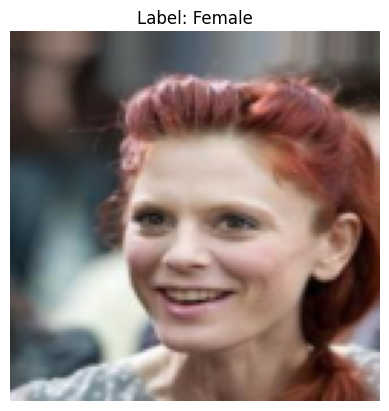

In [5]:
import matplotlib.pyplot as plt

# Pick an index to view
idx = 1
img, label = dataset[idx]

# If you used transforms.ToTensor(), convert back to NumPy for display
if hasattr(img, "permute"):  # tensor case
    img_np = img.permute(1, 2, 0).numpy()
else:  # PIL image case
    img_np = img

plt.imshow(img_np)
plt.title(f"Label: {'Male' if label == 1 else 'Female'}")
plt.axis('off')
plt.show()


In [6]:
df = pd.read_csv('data/celeba/list_attr_celeba.csv')

df['image_id']

0         000001.jpg
1         000002.jpg
2         000003.jpg
3         000004.jpg
4         000005.jpg
             ...    
202594    202595.jpg
202595    202596.jpg
202596    202597.jpg
202597    202598.jpg
202598    202599.jpg
Name: image_id, Length: 202599, dtype: object

In [7]:
persons = [[0.5935781598091125, 24.77481460571289, 178.0, 218.0]]

In [8]:
from models.detector.person_detector import PersonDetector
from models.detector.face_detector import FaceDetector
import cv2

image = cv2.imread(r"data\celeba\img_align_celeba\000002.jpg")
face_detector = FaceDetector()
person_detector = PersonDetector()

persons = person_detector.detect(image)



0: 640x544 1 person, 593.6ms
Speed: 13.2ms preprocess, 593.6ms inference, 20.9ms postprocess per image at shape (1, 3, 640, 544)


In [9]:
for person in persons:
    x_min, y_min, x_max, y_max = map(int, person)
    person_image = image[y_min:y_max, x_min:x_max] # Cropping
    person_faces = face_detector.detect(person_image)   


0: 640x608 1 face, 475.2ms
Speed: 8.5ms preprocess, 475.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
import cv2

In [1]:
from models.detector.person_detector import PersonDetector
from models.detector.face_detector import FaceDetector
from models.genderClassifier import GenderClassifierModel
import cv2

img = cv2.imread(r"data\test_images\woman-test.jpg")

person_detector = PersonDetector()
face_detector = FaceDetector()
gender_classifier = GenderClassifierModel()

persons_bbox = person_detector.detect(img)


x1, y1, x2, y2 = map(int, persons_bbox[0])
face_bbox = face_detector.detect(img[y1:y2, x1:x2])

fx1, fy1, fx2, fy2 = map(int, face_bbox[0])
face_crop = img[y1+fy1:y1+fy2, x1+fx1:x1+fx2]

gender_cls = gender_classifier.predict(face_crop)
print(gender_cls)


0: 448x640 1 person, 182.3ms
Speed: 8.9ms preprocess, 182.3ms inference, 13.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 face, 106.5ms
Speed: 3.0ms preprocess, 106.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
{'label': 'female', 'confidence': 0.9766005277633667, 'probs': [0.9766005277633667, 0.023399511352181435]}


d:\Projects\Github projects\woman_face_blur\models\genderClassifier.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type == "cuda"):


In [ ]:
l = [1,2,3]
l.